<a href="https://colab.research.google.com/github/beatricekiplagat/Deepfake-Audio-Recognition/blob/dev_branch/DEEP_TRANSFER_LEARNING_MODELS_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb


In [2]:
# import necessary libraries'
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# define train and test data
# from PIL import Image
# import glob
# train_path = []
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Spoof/*.png'):
#     im=Image.open(filename)
#     train_path.append(im)
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/*.png'):
#     im=Image.open(filename)
#     train_path.append(im)
# from PIL import Image
# import glob
# valid_path = []
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/*.png'):
#     im=Image.open(filename)
#     valid_path.append(im)
# for filename in glob.glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/*.png'):
#     im=Image.open(filename)
#     valid_path.append(im)

train_path ='/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train'
test_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test'

In [5]:
# add preprocessing layer to the front of VGG
# the include_top false statement will allow us to be able to set the number of classes on the top layer that we will create
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train - vgg has existing weights
for layer in vgg.layers:
  layer.trainable = False
  
 
  # useful for getting number of classes
  # this will count the number of classes we have in our dataset assuming that the data is grouped into specific folders
folders = glob('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/*')

In [6]:
# # our layers
# x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
# prediction = Dense(folders, activation='sigmoid')(x)
x = Flatten()(vgg.output)
prediction = Dense(1, activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:

# # create a model object
# model = Model(inputs=vgg.input, outputs=prediction)
# # view the structure of the model
# model.summary()


In [8]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

# from keras import optimizers


# adam = optimizers.Adam()
# model.compile(loss='binary_crossentropy',
#               optimizer=adam,
#               metrics=['accuracy'])

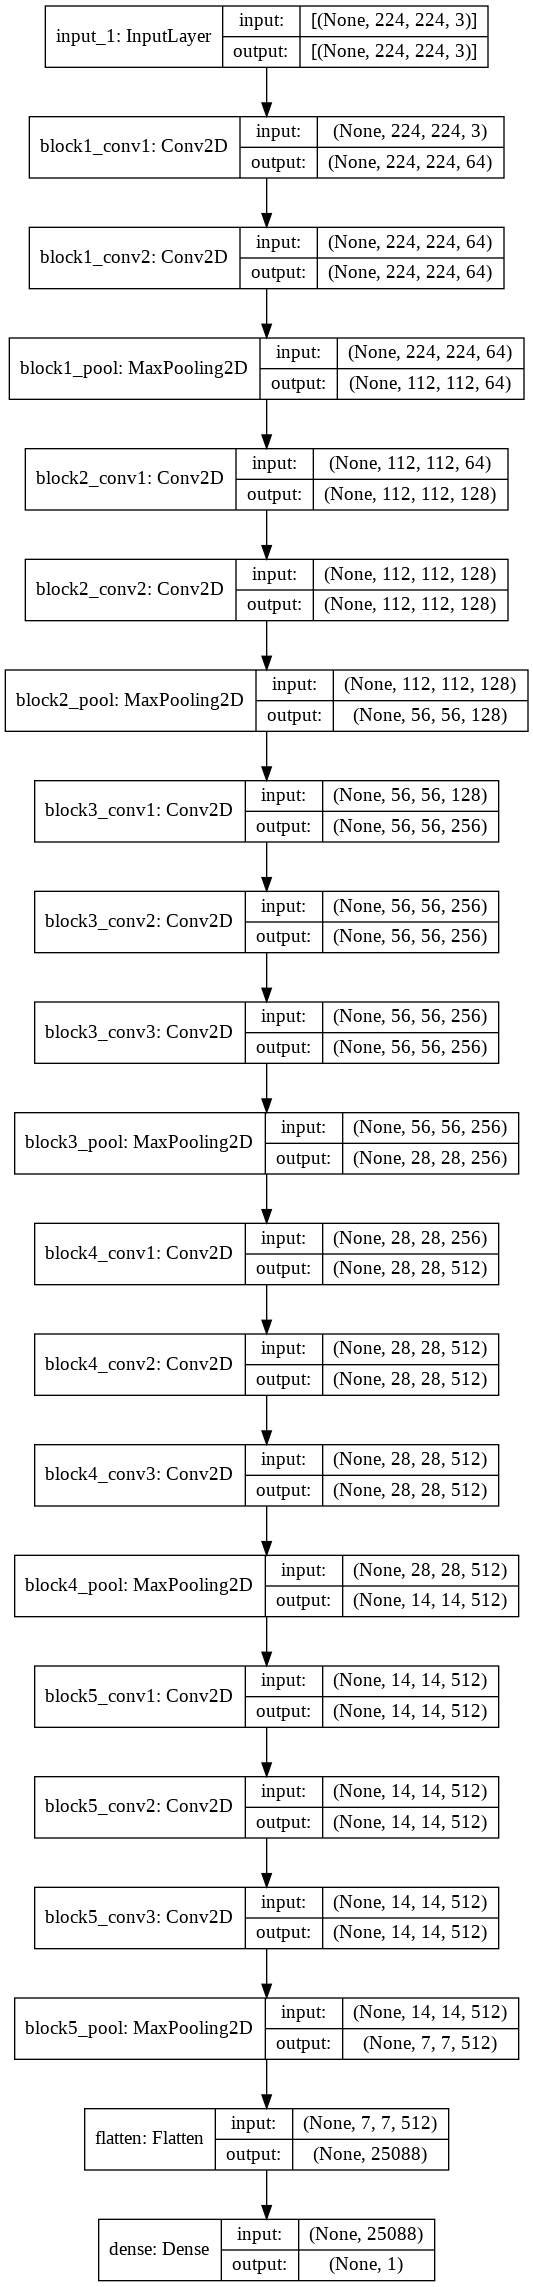

In [9]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'binary')





Found 1650 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [11]:
wandb.login()

wandb: Currently logged in as: ruoro (use `wandb login --relogin` to force relogin)


True

In [12]:
run = wandb.init(project='DeepFake Audio Detection', entity='ruoro', save_code=True, 
           config = {
               'learning_rate': 0.001,
               'epochs': 7,
               'batch_size' : 4,
               'loss_function' : 'binary_crossentropy'
           })
run

In [13]:
validation_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test',
  target_size=(224, 224),
  batch_size=4,
  class_mode='binary')

Found 400 images belonging to 2 classes.


In [36]:
labels = ['Spoof', 'Bonafide']
 # fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch= 20,  #len(training_set),
  validation_steps= 20,
  callbacks = [WandbCallback(data_type="image",labels=labels)] #len(test_set)
)

Epoch 1/20
20/20 [==============================] - 5s 241ms/step - loss: 0.3549 - accuracy: 0.8462 - val_loss: 0.3325 - val_accuracy: 0.8875


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 2/20
20/20 [==============================] - 4s 222ms/step - loss: 0.3737 - accuracy: 0.9125 - val_loss: 0.3599 - val_accuracy: 0.8625


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 3/20
20/20 [==============================] - 4s 224ms/step - loss: 0.3234 - accuracy: 0.8846 - val_loss: 0.2896 - val_accuracy: 0.8625


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 4/20
20/20 [==============================] - 5s 232ms/step - loss: 0.6004 - accuracy: 0.7500 - val_loss: 0.3386 - val_accuracy: 0.8125


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 5/20
20/20 [==============================] - 4s 221ms/step - loss: 0.3983 - accuracy: 0.8500 - val_loss: 0.4532 - val_accuracy: 0.7250


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 6/20
20/20 [==============================] - 4s 222ms/step - loss: 0.5381 - accuracy: 0.7750 - val_loss: 0.3326 - val_accuracy: 0.8125


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 7/20
20/20 [==============================] - 4s 222ms/step - loss: 0.3913 - accuracy: 0.8500 - val_loss: 0.6961 - val_accuracy: 0.6625


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 8/20
20/20 [==============================] - 4s 225ms/step - loss: 0.4911 - accuracy: 0.8000 - val_loss: 0.3359 - val_accuracy: 0.8000


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 9/20
20/20 [==============================] - 5s 241ms/step - loss: 0.2982 - accuracy: 0.8750 - val_loss: 0.3051 - val_accuracy: 0.8375


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 10/20
20/20 [==============================] - 5s 242ms/step - loss: 0.2738 - accuracy: 0.8625 - val_loss: 0.3148 - val_accuracy: 0.8625


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 11/20
20/20 [==============================] - 4s 225ms/step - loss: 0.3914 - accuracy: 0.8000 - val_loss: 0.3580 - val_accuracy: 0.8625


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 12/20
20/20 [==============================] - 5s 267ms/step - loss: 0.4044 - accuracy: 0.8250 - val_loss: 0.2198 - val_accuracy: 0.9125


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 13/20
20/20 [==============================] - 5s 239ms/step - loss: 0.4930 - accuracy: 0.7875 - val_loss: 0.4428 - val_accuracy: 0.7500


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 14/20
20/20 [==============================] - 4s 217ms/step - loss: 0.2799 - accuracy: 0.8875 - val_loss: 0.2932 - val_accuracy: 0.8750


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 15/20
20/20 [==============================] - 5s 231ms/step - loss: 0.2285 - accuracy: 0.9250 - val_loss: 0.2352 - val_accuracy: 0.8875


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 16/20
20/20 [==============================] - 4s 219ms/step - loss: 0.3822 - accuracy: 0.8125 - val_loss: 0.2631 - val_accuracy: 0.8625


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 17/20
20/20 [==============================] - 4s 219ms/step - loss: 0.3841 - accuracy: 0.8000 - val_loss: 0.5359 - val_accuracy: 0.7625


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 18/20
20/20 [==============================] - 4s 220ms/step - loss: 0.3338 - accuracy: 0.8500 - val_loss: 0.2748 - val_accuracy: 0.8875


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 19/20
20/20 [==============================] - 5s 231ms/step - loss: 0.2606 - accuracy: 0.9000 - val_loss: 0.2715 - val_accuracy: 0.9000


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 20/20
20/20 [==============================] - 5s 220ms/step - loss: 0.2265 - accuracy: 0.9125 - val_loss: 0.2793 - val_accuracy: 0.9000


wandb: WARNING No validation_data set, pass a generator to the callback.


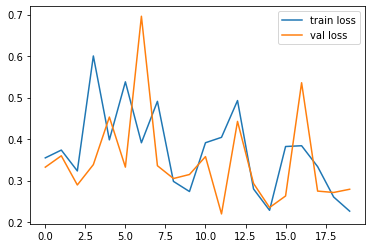

<Figure size 432x288 with 0 Axes>

In [37]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')



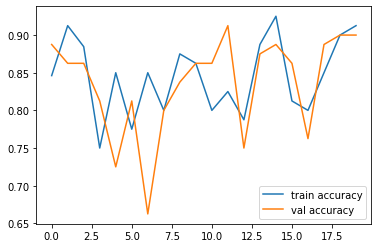

<Figure size 432x288 with 0 Axes>

In [38]:
# accuracies
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

import tensorflow as tf

from keras.models import load_model

model.save('VGG16v2.h5')


In [47]:
vgg = load_model('VGG16.h5')

In [48]:
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_3008473.png"
# '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/LA_D_1490681.png'
img = cv2.imread(img_path)
# img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x = np.expand_dims(img, axis=0)
# Now predict the class of image. 
preds = vgg.predict(x)

preds

array([[1.]], dtype=float32)

# grad cam of the model 


In [56]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import load_model

In [50]:
last_conv_layer_name = "block5_conv3"

In [51]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Predicted: [[153.49129]]


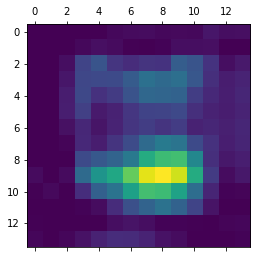

In [61]:

img_size =  [224,224]
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
# model = model_builder(weights="imagenet")
model = load_model('VGG16.h5')

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

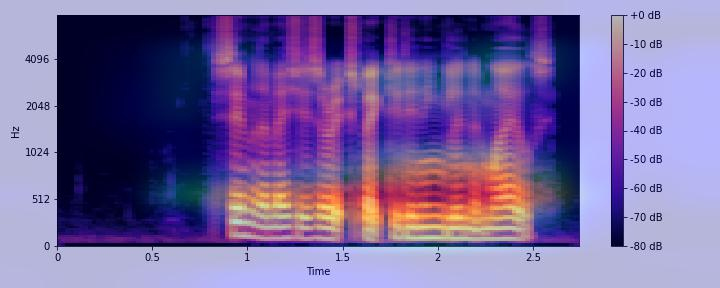

In [62]:

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

Input image shape: (1, 224, 224, 3)
[[1.]]


'Bonafide'

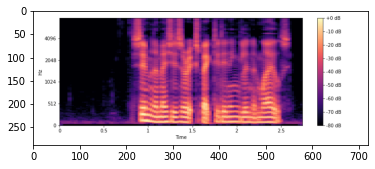

In [60]:
import cv2
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import os, sys


# img_path = '/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Train/Bonafide/Copy of LA_D_6787225.png'
img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/LA_D_1523180.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Bonafide/LA_D_3369144.png"

# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_5978963.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_3008473.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_8191193.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_8239585.png"
# img_path = "/content/drive/MyDrive/DEEPFAKE AUDIO DETECTION PROJECT/DATASETS/Test/Spoof/LA_D_9958023.png"


#image1_dir = os.path.join(test_path+'/Bonafide/LA_D_4033093.png')

def import_and_predict(image_data, label):
  #resize 
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))

  x = np.expand_dims(img, axis=0)
  x = preprocess_input(x)

  print('Input image shape:', x.shape)

  my_image = imread(img_path)
  imshow(my_image)
      
  #predict image
  prediction = vgg.predict(x)
  print(prediction)

  label_prediction = label[np.argmax(prediction)]

  return label_prediction

# label = os.listdir(test_path)


prediction = import_and_predict(img_path, label)
prediction

In [29]:
label = os.listdir(test_path)
label

In [41]:
# To save the model:
import tensorflow as tf

from keras.models import load_model

model.save('VGG16.h5')

In [44]:
model = wandb.Artifact('VGG16model', type='model')
model.add_file('VGG16v2.h5')

run.log_artifact(model)

Exception: ignored

In [43]:
wandb.finish()

accuracy,0.9125
best_epoch,12
best_val_loss,0.21295
epoch,19
loss,0.22646
val_accuracy,0.9
val_loss,0.27925


accuracy,▁▂▅▄▅▅▆▅▅▂▅▅▄▅▆▆▄▇▆▆▆▅▅▆▇▇▆▇▇▅▅▇▇▇▆▆█▆▇█
epoch,▁▁▂▂▃▄▄▅▅▆▇▇██▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▄▅▅▆▇▇█
loss,█▆▃▄▄▃▂▄▄█▃▃▄▃▂▂▄▂▂▂▃▃▃▂▂▂▂▂▂▄▃▂▂▁▂▃▁▂▂▁
val_accuracy,▁▂▅▅▆▆▆▆▄▄█▆▅▇▄▅▇▆█▇▅▄▆█▆▇▇▇▇▆▆▄▇▇█▅▇▇▇█
val_loss,█▃▃▃▂▃▂▃▂▅▁▂▃▁▃▃▂▂▁▂▃▃▂▁▂▁▁▂▁▂▂▃▁▁▁▂▁▁▁▁
